In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
test_labels = pd.read_csv('test_post_competition_scoring_clips.csv')
train_labels = pd.read_csv('train_post_competition.csv')

In [3]:
fname_train_verified = train_labels[train_labels.manually_verified==1].fname

In [4]:
train_labels_verified = train_labels[train_labels.manually_verified==1][['fname','label']]

In [5]:
test_labels_verified = test_labels[['fname','label']]

In [6]:
train_labels_verified.to_csv('trains_labels.csv')

In [7]:
test_labels_verified.to_csv('test_labels.csv')

In [8]:
import os
from tqdm import tqdm
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa 

In [9]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

#create signal envelope so se filter out low amplitude/noise
#Ref: https://www.youtube.com/watch?v=mUXkj1BKYk0
def envelope(y, rate, threshold):
    mask = []
    #we want a rolling window so we create series as it is easy with it
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
            
    return mask
    
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    
    return (Y, freq)
        

In [10]:
train_labels_verified.index = train_labels_verified.fname
for f in train_labels_verified.index:
    rate, signal = wavfile.read('FSDKaggle2018.audio_train/' + f)
    train_labels_verified.at[f, 'length'] = signal.shape[0]/rate

In [11]:
classes = list(np.unique(train_labels_verified.label))
class_dist = train_labels_verified.groupby(['label'])['length'].mean()

Text(0, 0.5, 'Mean length in s')

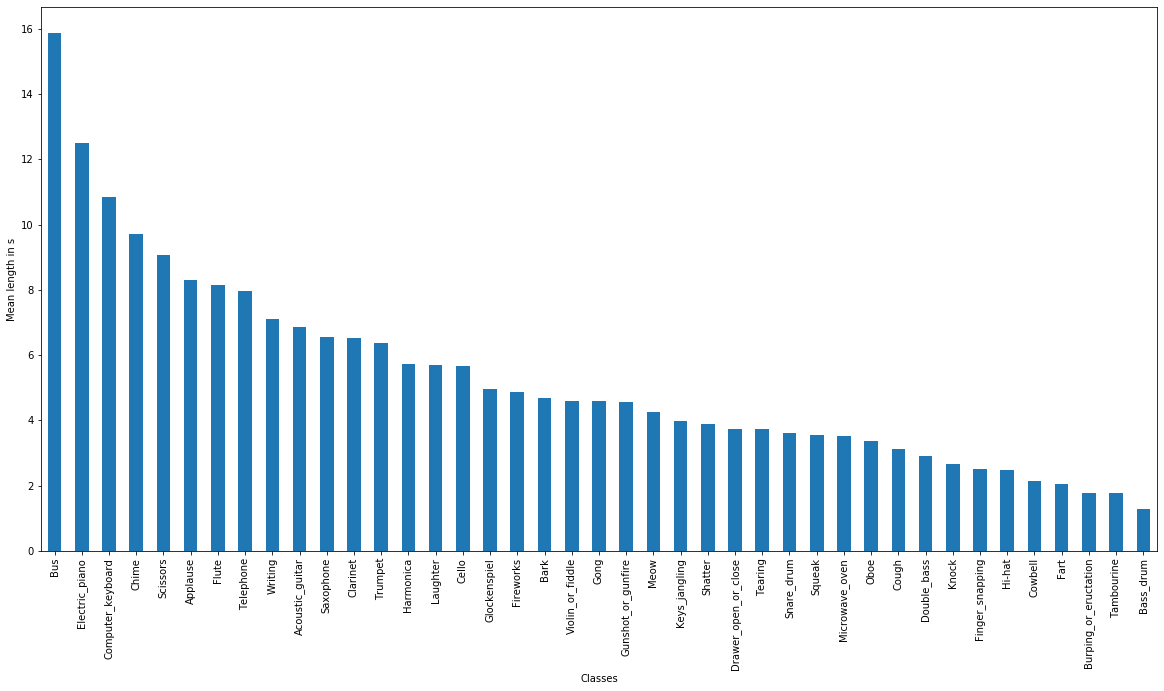

In [12]:
class_dist.sort_values(ascending=False,inplace=True)
ax = pd.DataFrame(class_dist).plot(figsize=(20,10),kind='bar',legend=False)
ax.set_xlabel("Classes")
ax.set_ylabel("Mean length in s")

In [13]:
df = train_labels_verified
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = df[df.label == c].iloc[0,0]
    signal, rate = librosa.load('FSDKaggle2018.audio_train/'+wav_file,sr=44100)
    mask = envelope(signal, rate, 0.0005) #0.0005 is experimental
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

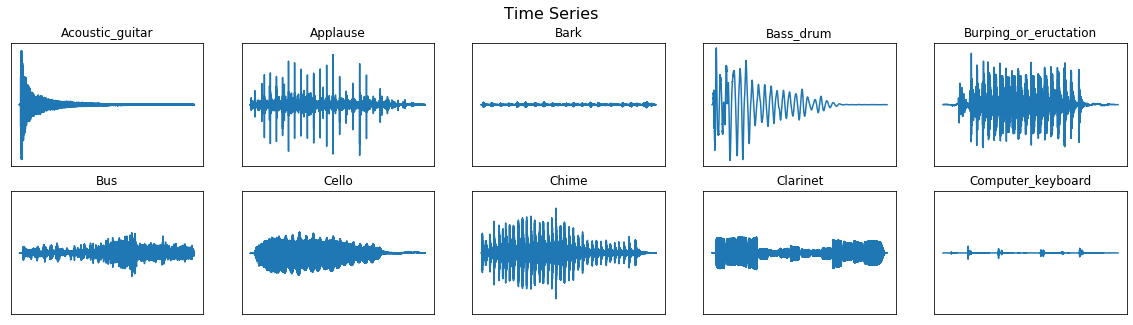

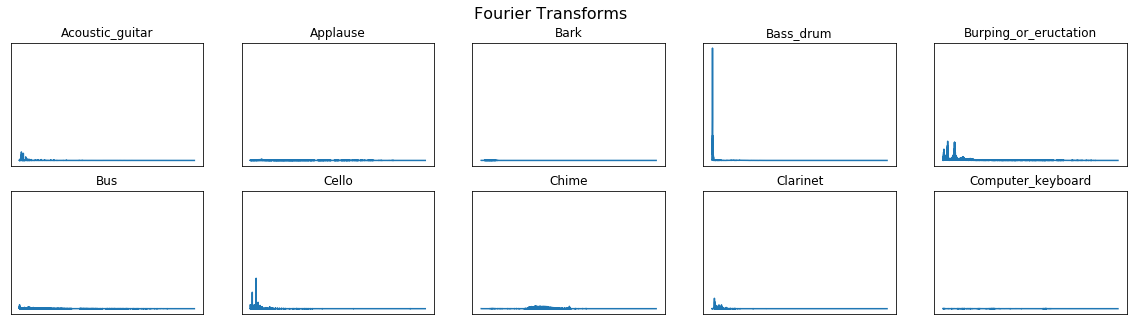

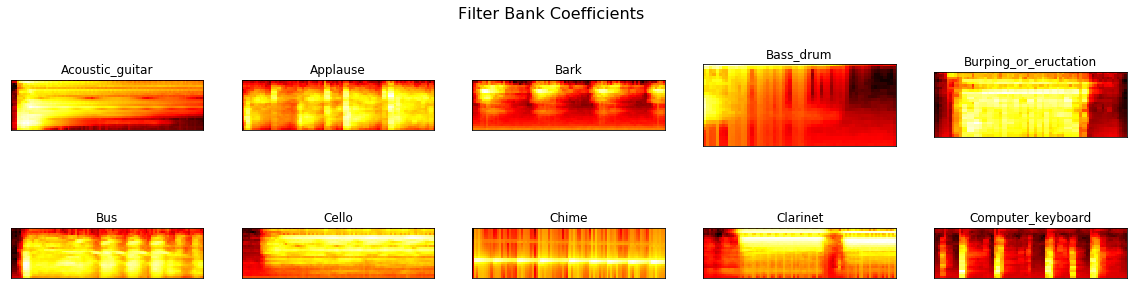

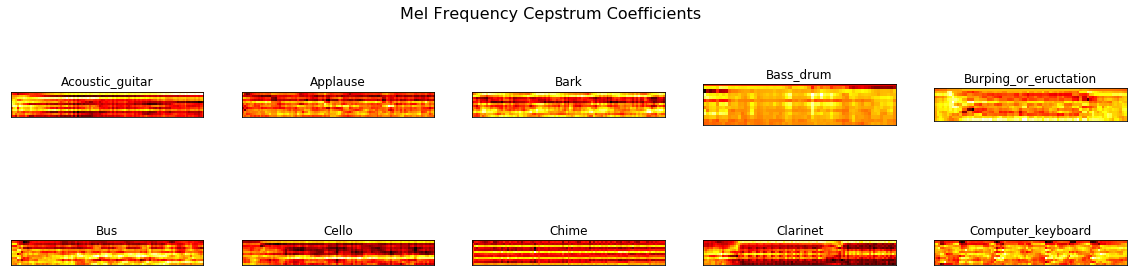

In [14]:
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [18]:
if len(os.listdir('clean_test')) == 0:
    for f in tqdm(test_labels_verified.fname):
        signal, rate = librosa.load('FSDKaggle2018.audio_test/'+f, sr=16000)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename='clean_test/'+f, rate=rate, data=signal[mask])

100%|██████████| 1600/1600 [07:20<00:00,  3.63it/s]
